In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import sys
sys.path.append('../src/fnc')

import LMPC
import SysModel
from Track import Map
import Utilities
import pwa_cluster as pwac

import matplotlib.pyplot as plt

In [17]:
trackMap = Map(0.8) 
dt = 0.1
n = 6; d = 2
state_names = ['vx', 'vy', 'wz', 'epsi', 's', 'ey']

n_data = 500

In [18]:
def generate_random_input():
    # x = [vx, vy, wz, epsi, s, ey]
    # u = [delta, a]
    x = np.random.uniform(size=[n]) * np.array([3, 1, 1, 1, trackMap.TrackLength, 2*0.8]) + np.array([0, 0, 0, 0, 0, -0.8])
    u = np.random.uniform(size=[d]) * np.array([1, 2]) + np.array([-0.5, -1])
    return x, u

def get_z_y_pair():
    x, u = generate_random_input()
    x_glob = trackMap.get_global_state(x)
    x_next, x_glob_next = SysModel._DynModel(x, x_glob, u, dt, trackMap.PointAndTangent)
    return np.hstack([x,u]), x_next


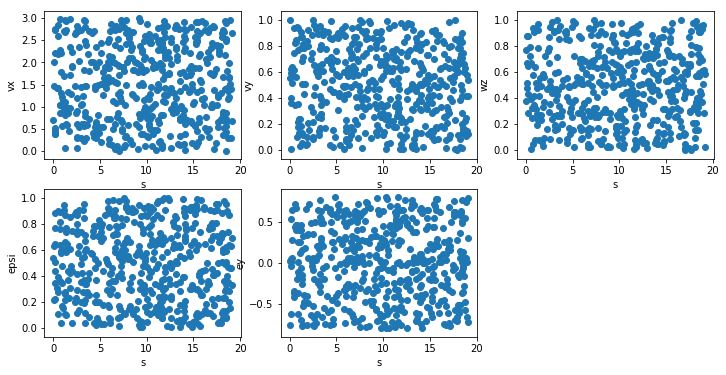

In [19]:
zs = []; ys = []
for i in range(n_data):
    z, y = get_z_y_pair()
    zs.append(z); ys.append(y)

zs = np.array(zs)
ys = np.array(ys)
    
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [20]:
nc_list = [2,3,4,5]
best_clustering, ind_perm = pwac.select_nc_cross_validation(nc_list, zs, ys, verbose=True, z_cutoff=n)


===================== Fitting model with Nc= 2 ====================
assigning datapoints to clusters
updating models
centroid movement 3.00745767212
assigning datapoints to clusters
updating models
centroid movement 1.25001347961
assigning datapoints to clusters
updating models
centroid movement 0.651360605254
assigning datapoints to clusters
updating models
centroid movement 0.181598791088
assigning datapoints to clusters
updating models
centroid movement 0.215736750154
assigning datapoints to clusters
updating models
centroid movement 0.17772024568
assigning datapoints to clusters
updating models
centroid movement 0.0
done
avg train error: 0.0262782118336
avg test error: [ 0.01179431  0.01544169  0.76326045  0.01836022  0.02450836  0.01242517
  0.15265209  0.01428562  0.03899871  0.33392645  0.01345799  0.01701536
  0.03318524  0.01957078  0.01712443  0.05565441  0.06596078  0.01312733
  0.01377016  0.01509272  0.0171795   0.01113088  0.01475918  0.04206947
  0.04047593  0.03035695  

In [21]:
best_clustering.Nc

2

In [22]:
best_clustering.determine_polytopic_regions(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 8000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 514, constraints m = 1000
Cones:	linear vars: 1000
Setup time: 2.13e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 7.90e-01  3.76e-01  3.75e-01 -3.24e-01  2.75e-01  1.33e-16  8.23e-02 
   100| 2.26e-02  1.38e-02  3.78e-03  9.80e-03  1.37e-02  4.41e-17  1.04e-01 
   200| 1.41e-07  2.35e-08  1.88e-08 -1.88e-08 -0.00e+00  3.46e-17  1.25e-01 
-----------------------------------------------------------

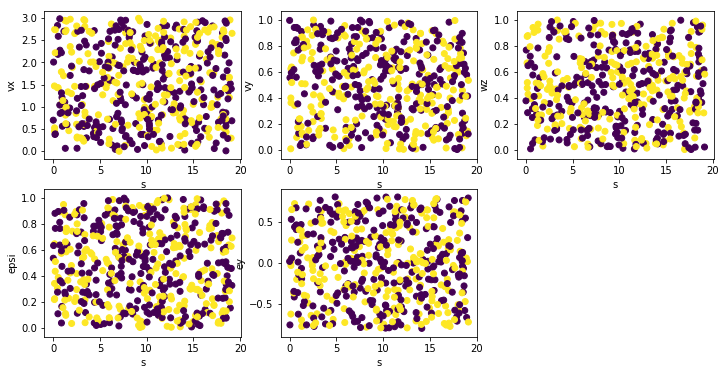

In [24]:
plt.figure(figsize=[12,6])
for i in range(n-1):
    plt.subplot(2, 3, i+1)
    ind = i if i < 4 else 5
    plt.scatter(zs[:,4], zs[:,ind], c=best_clustering.cluster_labels[ind_perm])
    plt.xlabel(state_names[4]); plt.ylabel(state_names[ind])

In [10]:
# self.clustering = pwac.ClusterPWA.from_labels(zs, ys, 
#                                data['labels'], z_cutoff=self.n)
# self.clustering.region_fns = data['region_fns']
np.savez('pwa_model_'+str(best_clustering.Nc), labels=best_clustering.cluster_labels, region_fns=best_clustering.region_fns, 
         thetas=best_clustering.thetas, zs=zs, ys=ys)

In [8]:
print(x_next)
print(x_glob_next)

[  0.40271081  -0.0565205   -0.51047363   0.06231556  11.55229491
  -0.59633254]
[ 0.40362651 -0.05722567 -0.51032248  3.10423143 -2.42395266 -3.05482882]
